**Enable GPU** (Runtime > Change runtime type > GPU)

In [1]:
!nvidia-smi

Fri Sep 16 10:07:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Clone MddGAN repo

In [2]:
import os

os.chdir('/content')
CODE_DIR = 'mddgan'
!git clone https://github.com/lazavgeridis/mddgan.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')

Cloning into 'mddgan'...
remote: Enumerating objects: 375, done.
remote: Counting objects: 100% (375/375), done.
remote: Compressing objects: 100% (298/298), done.
remote: Total 375 (delta 156), reused 294 (delta 75), pack-reused 0
Receiving objects: 100% (375/375), 28.96 MiB | 11.87 MiB/s, done.
Resolving deltas: 100% (156/156), done.


In [3]:
!pip install tensorly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 198 kB 37.0 MB/s 
     |████████████████████████████████| 154 kB 67.0 MB/s 


GAN Model Selection

In [4]:
#@title { display-mode: "form", run: "auto" }
gan_model_name = "stylegan_celebahq1024" #@param ['stylegan_ffhq1024', 'stylegan_celebahq1024']

Build selected GAN model and load pre-trained weights

In [5]:
from models import parse_gan_type
from utils  import load_generator, parse_indices

generator = load_generator(gan_model_name).cuda()
gan_type  = parse_gan_type(generator)

Building generator for model `stylegan_celebahq1024` ...
Finish building generator.
Loading checkpoint from `checkpoints/stylegan_celebahq1024.pth` ...
  Finish downloading checkpoint.
Finish loading checkpoint.


Utility Functions

In [12]:
from visualization import postprocess, interpolation
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

def create_horizontal_chart(generator,
                            gan_type,
                            directions,
                            text,
                            layer_indices,
                            latent_codes,
                            magnitudes,
                            step,
                            n_samples=1):
  
  fig, axs = plt.subplots(nrows=n_samples, ncols=len(directions), dpi=600, constrained_layout=True)

  for sample_idx in range(n_samples):
    code_idx = int(input(f'> Choose latent code index to use for comparison (0 < index < {latent_codes.size(0) - 1}) : '))
    code = latent_codes[code_idx: code_idx + 1]

    for direction_idx, ax in enumerate(axs.flat):
      #ax = axs[direction_idx] if n_samples == 1 else axs[sample_idx, direction_idx]
      ax.axis('off')
      ax.imshow(postprocess(make_grid(interpolation(generator, layer_indices[direction_idx], gan_type, code, directions[direction_idx], magnitudes), nrow=step)))
      ax.text(0.5, 0, 
               text[direction_idx], 
               horizontalalignment='center',
               verticalalignment='top', 
               fontsize='small',
               transform=ax.transAxes)

Set random seed for reproducibility

In [13]:
import torch
import numpy as np

# set random seed
seed = 13
np.random.seed(seed)
torch.manual_seed(seed)

# prepare interpolation magnitudes
start = -2.0  #-2.0, -3.0, -5.0
end = 2.0     # 2.0, 3.0, 5.0
step = 3
magnitudes = np.linspace(start, end, step)

num_samples = 20
codes = torch.randn(num_samples, generator.z_space_dim, device='cuda')
if gan_type == 'pggan':
  codes = generator.layer0.pixel_norm(codes)
elif gan_type in ['stylegan', 'stylegan2']:
  trunc_psi = 0.7
  trunc_layers = 8
  codes = generator.mapping(codes)['w']
  codes = generator.truncation(codes, trunc_psi=trunc_psi, trunc_layers=trunc_layers)
codes = codes.detach().cpu()

Create horizontal chart

> Choose latent code index to use for comparison (0 < index < 19) : 19


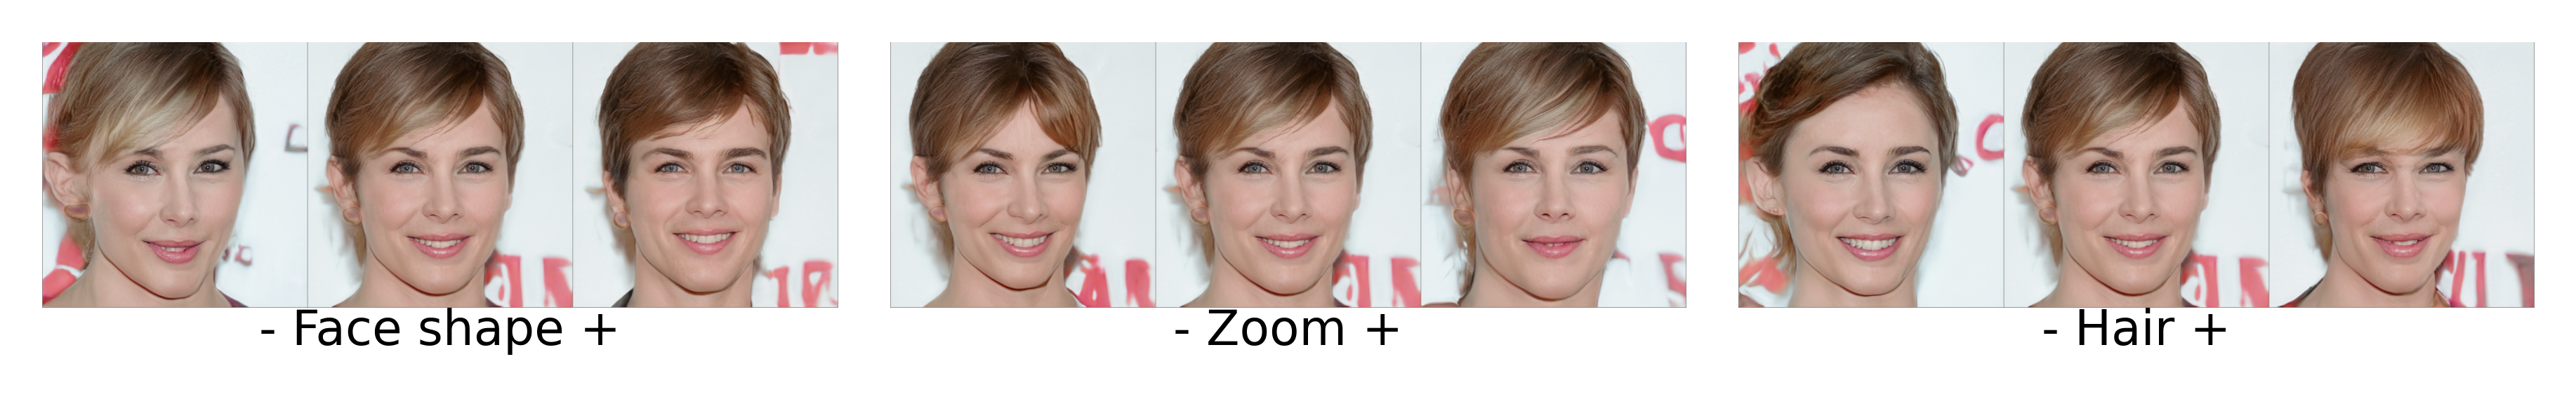

In [14]:
from directions import ATTRIBUTES

SEMANTICS_DIR = 'semantics'

# choose and load semantic attribute for both methods
#ATTRIBUTES_FFHQ = {'pose' : '0-6', 'gender' : '2-4', 'age' : '2,4,5,6', 
#                   'smile' : '3', 'eyeglasses' : '0-2', 'race1' : '7-12',
#                   'race2' : '5-7', 'lighting' : '5-8'}
#ATTRIBUTES_CELEBAHQ = {'pose' : '0-3', 'gender' : '0-1', 'age' : '5-7', 
#                       'smile' : '0-3', 'eyeglasses' : '0-1', 
#                       'face_shape_1' : '2', 'face_shape_2' : '0-1', 
#                       'zoom' : '0-3', 'hair' : '1-3'}

celebahq_attributes = ['face_shape_1', 'zoom', 'hair']
ffhq_attributes = ['race1', 'race2', 'lighting']

if gan_model_name == 'stylegan_celebahq1024':
  attributes = celebahq_attributes
elif gan_model_name == 'stylegan_ffhq1024':
  attributes = ffhq_attributes

directions = []
layer_indices = []
text = []
for attr_name in attributes:
  mddgan_semantic = np.load(f'semantics/mddgan/{gan_model_name}_{attr_name}.npy')
  directions.append(mddgan_semantic)

  # retrieve layers to apply the edit
  model_attributes = ATTRIBUTES[gan_model_name]
  layer_range, _ = model_attributes[attr_name]
  layers = parse_indices(layer_range, min_val=0, max_val=generator.num_layers - 1)
  layer_indices.append(layers)

  desc = attr_name.split('_')
  desc = ' '.join(desc).capitalize()
  if desc == 'Race1':
    desc = 'Skin tone'
  elif desc == 'Race2':
    desc = 'Eyes shape'
  elif desc == 'Face shape 1':
    desc = 'Face shape'
  text.append(f'- {desc} +')

create_horizontal_chart(generator,
                        gan_type,
                        directions,
                        text,
                        layer_indices,
                        codes,
                        magnitudes,
                        step,
                        n_samples=1)

In [15]:
#RESULTS_DIR = 'results'
#
## draw horizontal line
##line = plt.Line2D([0.1, 0.9], [0.5, 0.5], color="k", linewidth=1)
##fig.add_artist(line)
#
##grid = draw_chart(fig)
#out_file = os.path.join(RESULTS_DIR, 
#                        f'mddgan_{model_name}_diversity.jpg')
#fig.savefig(out_file, bbox_inches='tight')
#fig.clf()
#plt.close(fig)
##Image.fromarray(grid).save(out_file) 